In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease/processed.cleveland.data


**Patient Heart Disease Prediction**

In this notebook, I will build a Support Vector Machine (SVM) using the Radial Basis Function (RBF) Kernel. The dataset comes from the UCI Machine Learning Repository to predict whether a patient has heart diseas or not. 

**Support Vector Machines**

Support Vector Machines (SVM) are one the best machine learning models when getting the correct answer is a higher priority than understanding why you got the correct answer, and they work really well with relatively small datasets. SVMs are indeed powerful tools for classification and regression tasks where accuracy is paramount. They excel at finding the optimal decision boundary that maximizes the margin between classes, making them less prone to overfitting, especially with limited data. This ability to generalize well from small datasets is a significant advantage in situations where data collection is expensive or time-consuming.

**Radial Based Function**

In this notebook, as previously established, I'll be using a Support Vector Machine (SVM) with the Radial Basis Function (RBF) kernel, also known as the Gaussian kernal, to predict heart disease in patients. The RBF kernel is a popular choice for SVMs because it's incredibly versatile. It can learn complex, non-linear patterns in the data, which is crucial for medical diagnoses where the relationship between risk factors and disease isn't always straightforward

The RBF kernel is defined as the following:

K(x, y) = exp(-gamma * ||x - y||^2)

where:

x and y are two data points (in this case, two patients' feature vectors)
||x - y|| is the Euclidean distance between these data points
gamma (γ) is a hyperparameter controlling the kernel's width or influence

Think of the RBF kernel as a similarity measure, where a  small distance translates to high similarity, and a large distance translates to low similarity. It looks at how close data points are to each other in a high-dimensional space.  In this heart disease project, each patient is a data point, and their features determine their position in this space. The RBF kernel helps me figure out how similar different patients are based on these features.

By using the RBF kernel, my SVM can create a decision boundary that isn't just a straight line. This allows it to capture the nuances in the data and potentially make more accurate predictions about who is likely to have heart disease

In [2]:
# Import necessary libraries and packages
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import seaborn as sns

In [3]:
# Load in the dataset
df= pd.read_csv('/kaggle/input/heart-disease/processed.cleveland.data', header= None)

In [4]:
# View the data
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


**Organizing the Columns**

Instead of seeing columns names, right now there are just column numbers. Having columns names would certainly make it easier to format the data. So I will proceed to replace the columns numbers with the following column names:

**Data Dictionary**:

1. **age** - Age
2. **sex** - Sex
3. **cp** - Chest pain
4. **restbp** - Resting blood pressure (in mm Hg)
5. **chol** - Serum cholesterol (in mg/dl)
6. **fbs** - Fasting blood sugar
7. **restecg** - Resting electrocardiographic results
8. **thalach** - Maximum heart rate achieved
9. **exang** - Exercise-induced angina
10. **oldpeak** - ST depression induced by exercise relative to rest
11. **slope** - The slope of the peak exercise ST segment
12. **ca** - Number of major vessels (0-3) colored by fluoroscopy
13. **thal** - Thalium heart scan
14. **hd** - Diagnosis of heart disease (target feature)



In [5]:
# Replace column numbers with column names
df.columns = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 
              'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd']
df.head(10)

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


In [6]:
# Explore the data
df.shape

(303, 14)

In [7]:
# Check data types
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

**Data Types**

Upon examining the data types, I notice that most columns are of type float64. However, the columns 'ca' and 'thal' are of type object, while the column 'hd' is of type int64.

The object data types for 'ca' and 'thal' indicate that these columns might contain a mix of different data types, such as numbers and letters. Ideally, 'ca' and 'thal' should contain categorical values only. To understand this further, I will investigate by printing the unique values in these columns, starting with 'ca'

In [8]:
# Investigate 'ca' column
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

**'ca' Column**

Since the column has the object data type, it implies that the values are stored as strings instead of numeric types. This is because the '?' value cannot be interpreted as a number, forcing the entire column to be treated as an object

In [9]:
# Investigate 'thal' columns
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

**'thal' Column**

Same idea here as with the 'ca' column.

**Missing Values**

Since scikit-learn's Support Vector Machines do not support datasets with missing values, it is important that these missing values are handled. 

In [10]:
# Identify missing values in 'ca' and 'thal' columns
len(df.loc[(df['ca'] == '?') | (df['thal'] == '?')])

6

- This means that there are only 6 rows within the 'ca' or 'thal' columns that contain '?'. In other words, there are 6 instances where these columns have missing or invalid data represented by '?'. Now, I'm going to take a look at these rows.

In [11]:
# Viewing the missing values in 'ca' and 'thal' columns
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


**Handling Missing Values**

So, 6 out of the 303 rows, or approximately 2%, contain missing values. Since 297 rows provides sufficient data for building the support vector machine, I will proceed by removing the rows with missing values rather than attempt to impute them.

In [12]:
# Creating a new df without missing values and verify changes
df_new= df.loc[(df['ca'] != '?') & (df['thal'] != '?')]
df_new.shape

(297, 14)

In [13]:
# Verifying 'ca' column
df_new['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [14]:
# Verifying 'thal' column
df_new['thal'].unique()

array(['6.0', '3.0', '7.0'], dtype=object)

- Great! I have now confirmed that the new dataframe, df_new, does not contain any missing values. Note that 'ca' and 'thal' still have the object data type, but that's fine for now. Now, I'm ready to format the data for building the Support Vector Machine.

In [15]:
# Split the data into input features and the target feature
X= df_new.drop(columns= ['hd'])
y= df_new['hd']

# Ensure that X and y have the same shape
print(f'X.shape: {X.shape}, y.shape: {y.shape}')
assert len(X) == len(y), 'The lengths of X and y are inconsistent!' 

X.shape: (297, 13), y.shape: (297,)


**One-Hot Encoding**

Now that I have split the dataframe into two parts, X and y, where X contains the features I will use to make predictions, and y contains the target feature with known classifications, it's important to examine the variables in X more closely. The following list describes each variable, its type (float or categorical), and its possible values:

**age**: Float

**sex**: Categorical

0 = female,
1 = male

**cp (chest pain)**: Categorical

1 = typical angina,
2 = atypical angina,
3 = non-anginal pain,
4 = asymptomatic

**restbp (resting blood pressure in mm Hg)**: Float

**chol (serum cholesterol in mg/dl)**: Float

**fbs (fasting blood sugar)**: Categorical

0 = >= 120 mg/dl,
1 = < 120 mg/dl

**restecg (resting electrocardiographic results)**: Categorical

1 = normal,
2 = having ST-T wave abnormality,
3 = showing probable or definite left ventricular hypertrophy

**thalach (maximum heart rate achieved)**: Float

**exang (exercise-induced angina)**: Categorical

0 = no,
1 = yes

**oldpeak (ST depression induced by exercise relative to rest)**: Float

**slope (the slope of the peak exercise ST segment)**: Categorical

1 = upsloping,
2 = flat,
3 = downsloping

**ca (number of major vessels (0-3) colored by fluoroscopy)**: Float

**thal (thalium heart scan)**: Categorical

3 = normal (no cold spots),
6 = fixed defect (cold spots during rest and exercise),
7 = reversible defect (cold spots only appear during exercise)

To correctly prepare the data for the Support Vector Machine model, I need to perform one-hot encoding on the categorical variables. This is an important process because it converts the categorical values into a format the the machine learning algorithms can work with in order to do a better job in the predictions. 

In [16]:
# Check the data types for the input features
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

**Input Features Data Types**

The columns 'age', 'restb'p, 'chol', and 'thalach' are all of type float64, which is appropriate since I want these to be floating point numbers. However, the other columns need to be inspected to ensure they contain only valid values, and some will need to be transformed. This is because, while scikit-learn's Support Vector Machines can natively handle continuous data (like restbp and thalach), they do not natively support categorical data (like cp, which has 4 categories). To use categorical data with scikit-learn's Support Vector Machines, I must convert a column of categorical data into multiple columns of binary values using a method called One-Hot Encoding.

It's very important to note that categorical data must not be treated as continuos data. Let's use the 'cp' (chest pain) column as an example to explain this concept, which has 4 categories:

- Typical angina
- Atypical angina
- Non-anginal pain
- Asymptomatic

If these categories were treated as continuous data, there would be an incorrect assumption that the category '4' (asymptomatic) is more similar to '3' (non-anginal pain) than it is to '1' (typical angina) or '2' (atypical angina). This could lead the Support Vector Machine to cluster patients with 4s and 3s together more frequently than patients with 4s and 1s. However, if these numbers are treated as categorical data, each category is considered as distinct and equally different from the others. This approach prevents the algorithm from making false assumptions about the similarity between different categories, leading to more accurate clustering.

Now, I will proceed to examine and, if necessary, convert the columns containing categorical and integer data into the appropriate data types.

In [17]:
# Checking 'cp'
X['cp'].unique()

array([1., 4., 3., 2.])

In [18]:
# Transform 'cp'
pd.get_dummies(X, columns= ['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,True,False,False,False
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,False,False,False,True
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,False,False,True,False
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,False,True,False,False


**1s & 0s over True or False**

True or False is not what I'm looking for. I want the 1s and the 0s because most machine learning algorithms, including Support Vector Machines, expect numerical input. So using 1s and 0s is better for compatability. Also, numerical data can be processed more efficiently.

In [19]:
# Going for the 1s and the 0s
cp_encoded= pd.get_dummies(X['cp'], prefix= 'cp').astype(int)

# Display the first few rows to see the result
print(cp_encoded.head())

   cp_1.0  cp_2.0  cp_3.0  cp_4.0
0       1       0       0       0
1       0       0       0       1
2       0       0       0       1
3       0       0       1       0
4       0       1       0       0


**1s & 0s**

From the printout above, it is clear that the get_dummies() function successfully split 'cp' into 4 columns as expected. For example, cp_1.0 is 1 for any patient with a chest pain score of 1 and 0 for all others, and so on and so forth. 

Now I will proceed to do this same process for the categorical columns that have more than two categories. 

In [20]:
# Transforming categorical columns with One-Hot encoding
restecg_encoded= pd.get_dummies(X['restecg'], prefix= 'restec').astype(int)

# One-Hot encode 'slope' column
slope_encoded= pd.get_dummies(X['slope'], prefix= 'slope').astype(int)

# One-Hot encode 'thal' column
thal_encoded= pd.get_dummies(X['thal'], prefix= 'thal').astype(int)

In [21]:
# Drop the original 'cp', 'restecg', 'slope' and 'thal' columns
X= X.drop(columns= ['cp', 'restecg', 'slope', 'thal'])

# Concatenate the dataframe with the new one-hot encoded columns
X= pd.concat([X, cp_encoded, restecg_encoded, slope_encoded, thal_encoded], axis= 1)

# Display the first few rows to view the result
X.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restec_0.0,restec_1.0,restec_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


**More Categorical Columns**

"Now let's discuss the three categorical columns that only contain 0s and 1s: 'sex', 'fbs' (fasting blood sugar), and 'exang' (exercise-induced angina). Unlike columns with more than two categories, like 'cp' (chest pain), which are now converted into multiple columns of 0s and 1s through One-Hot Encoding, these columns already have binary values. Therefore, no additional processing is needed for them. This means that no more data formatting is need for the Support Vector Machine. 

**Target Feature- Heart Disease**

It's important to note that since I'm only making a Support Vector Machine that does simple classification that will only predict if someone has heart disease or not, I need to convert all numbers to 1s and 0s. 

The target feature for the machine learning model, y, doesn't just contain 1s and 0s. Instead, it has 5 different levels of heart disease. 0 = no heart disease and 1-4 are various degrees of heart disease.

In [22]:
# Confirming the categories for the target feature
y.unique()

array([0, 2, 1, 3, 4])

In [23]:
# Convert target feature to 1s and 0s and verify transformation
y= y.apply(lambda x: 1 if x > 0 else 0)
y.unique()

array([0, 1])

**Centering & Scaling**

The Radial Basis Function (RBF) that's going to be used with the Support Vector Machine (SVM) assumes that the data is centered and scaled. So, this needs to be done to both the training and test datasets. What this process means is that the data will be adjusted to have a mean of 0 and a standard deviation (or the spread of variance) of 1. 

It's important to know that the RBF kernel l measures the similarity between pairs of data points. If features are on different scales, the SVM might give more importance to features with larger scales, skewing the results, which would not be a desired output. Furthermore, scaling ensures that each feature contributes equally to the similarity measure, preventing features with larger ranges from dominating the model. Finally, many machine learning algorithms, including SVMs, perform better when the data is scaled because it ensures the optimization process converges more efficiently.

In the next step, the data will be split into training and test sets and then they will be scaled separately. This is to avoid data leakage, which is when information about the training dataset "leaks", corrupts or influence the testing dataset. 

In [24]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state= 42)
X_train_scaled= scale(X_train)
X_test_scaled= scale(X_test)

**Support Vector Machine**

Now that the data is correctly formatted, I can proceed with building the Support Vector Machine.

Note, 'clf_svm' just means classifier Support Vector Machine. 

In [25]:
# Classifier SVM
clf_svm= SVC(kernel= 'rbf', random_state= 42)

# Fit the model
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [26]:
# Print the default parameters
print('Default parameters of the SVM model:')
print(clf_svm.get_params())

Default parameters of the SVM model:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


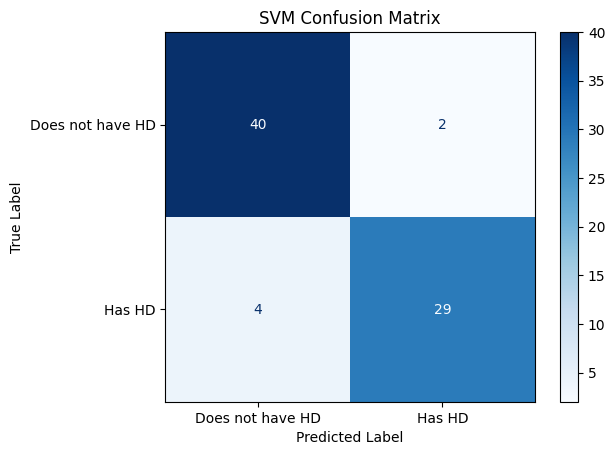

In [27]:
# Confusion Matrix with test data
disp= ConfusionMatrixDisplay.from_estimator(clf_svm, X_test_scaled, y_test, display_labels= ['Does not have HD', 'Has HD'], cmap= plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

**Confusion Matrix Analysis**

The confusion matrix reveals that the SVM model correctly predicted that 40 patients do not have heart disease, which accounts for approximately 87% of the true negatives. However, the model incorrectly predicted that 2 patients have heart disease when they do not, representing about 4% of the false positives. Additionally, the model incorrectly predicted that 4 patients do not have heart disease when they actually do, accounting for roughly 9% of the false negatives. On the positive side, the model accurately predicted that 29 patients have heart disease, which makes up about 87% of the true positives.

The model demonstrates strong performance with a good balance between sensitivity (recall or the true positive rate) (87%) and specificity (true negative rate) (87%), which is crucial in medical diagnosis scenarios where both false positives (4%) and false negatives (9%) can have significant implications.

The model's predictions can potentially be improved by using cross-validation. Cross-validation is a technique used to assess the generalizability of a model by partitioning the data into subsets, training the model on some subsets while validating it on others, and rotating this process multiple times. This helps in selecting the best hyperparameters and provides a better estimate of the model's performance by ensuring that the model generalizes well to unseen data.

**Optimizing a Support Vector Machine**

Optimizing a Support Vector Machine (SVM) involves finding the best values for the gamma parameter and, potentially, the regularization parameter, C. The 'gamma' (kernel coefficient) parameter defines how far the influence of a single training example reaches. It determines the influence of individual data points on the decision boundary. The 'C' parameter (regularization parameter) controls the trade-off between achieving a low training error and a low testing error, which means balancing between overfitting and underfitting. By fine-tuning these parameters, the accuracy of the model should improve on the testing dataset. 

To find the optimal values for gamma and C, I will use GridSearchCV(). This method specifies a range of potential values for both parameters, and then tests all possible combinations to identify the best ones through cross-validation.

In [28]:
# Optimizing the SVM
param_grid= [{'C': [1,10,100,100],
              'gamma': [0.001,0.0001],
              'kernel': ['rbf']
             }]

optimal_params= GridSearchCV(SVC(), param_grid, cv= 5, verbose= 0)

# Fitting the optimal params
optimal_params.fit(X_train_scaled, y_train)

# Get the best parameters
optimal_params.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

**Optimal Parameter Analysis**

The result {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'} indicates that the optimal parameters found by GridSearchCV for your Support Vector Machine (SVM) model using the Radial Basis Function (RBF) kernel are:

- **C**: 100
- **gamma**: 0.001
- **kernel**: 'rbf'

A value of 100 for 'C' is relatively high, which means the model is being penalized heavily for misclassifying training examples. The SVM is aiming to classify all training examples correctly by allowing the decision boundary to be more flexible. This can reduce bias and improve the fit of the model on the training data, but it also increases the risk of overfitting if C is too large.

A 'gamma' value of 0.001 is relatively low, meaning that each training example's influence reaches far in terms of defining the decision boundary. This results in a smoother and less complex decision boundary. A lower 'gamma' reduces the risk of overfitting by preventing the decision boundary from becoming too specific to the training data.

The combination of a high 'C' value and a low 'gamma' value suggests that the model is designed to balance between bias and variance. The high 'C' reduces bias by correctly classifying training examples, while the low 'gamma' prevents high variance by smoothing the decision boundary.

And finally, there is the RBF kernel, which is a popular choice for SVMs because it can handle the non-linear relationships between the features and the target variable. It maps the input space into a higher-dimensional space where a linear separation is possible.

Just for clarity, in the context of Support Vector Machines (SVMs), the decision boundary is a hyperplane or surface that separates the different classes in the feature space. For a binary classification problem, it is the line, plane, or hyperplane that best separates the two classes based on the features of the data

Now that I have the ideal values for 'C' and 'gamma', I will proceed to build the final Support Vector Machine. 

In [29]:
# SMV with optimal parameters
clf_svm= SVC(C= 100, gamma= 0.001, random_state= 42)

# Fit the model
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

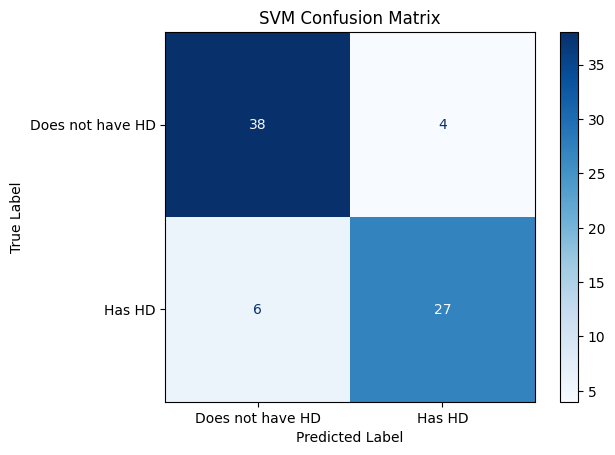

In [30]:
# Confusion Matrix with optimal parameters
# Confusion Matrix with test data
disp= ConfusionMatrixDisplay.from_estimator(clf_svm, X_test_scaled, y_test, display_labels= ['Does not have HD', 'Has HD'], cmap= plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

**Updated Confusion Matrix**

The matrix indicates that the model correctly predicted that 38 patients do not have heart disease, accounting for approximately 86% of the true negatives. However, it incorrectly predicted that 4 patients have heart disease when they do not, representing about 9% of the false positives. Additionally, the model incorrectly predicted that 6 patients do not have heart disease when they actually do, accounting for roughly 14% of the false negatives. On the positive side, the model accurately predicted that 27 patients have heart disease, which makes up about 82% of the true positives.

The model demonstrates strong performance with a sensitivity of 82% and a specificity of 86%. Sensitivity measures the model's ability to correctly identify patients with heart disease, while specificity measures the model's ability to correctly identify patients without heart disease. Both false positives (9%) and false negatives (14%) have been minimized compared to the original model, indicating an improvement in the model's predictive accuracy and generalizability. This balance is crucial in medical diagnosis scenarios, where both types of errors can have significant implications.

So, the model's predictions were indeed improved by using cross-validation. 

**Decisioun Boundary**

The last step I'm going to perform here is to draw the decision boundary. The first step I'm going to take in this process is to define the features in X. 

In [31]:
# Features in X
len(df.columns)

14

**14 Columns Problem**

Having 14 columns is a problem because that would require a 14-dimensional graph, one dimension per feature. An effective approach to tackle this problem would be to use Principal Component Analysis (PCA). PCA is a a dimensionality reduction technique that transforms a large set of correlated features into a smaller set of uncorrelated features called principal components. It helps simplify the data while retaining most of the original variance, making it easier to visualize and analyze. So, in this case, PCA helps combine the 14 features into 2 orthogonal meta-features, which can then be used as axes for a graph.

However, before doing so, it's important to determine how accurate the reduced dimensionality graph will be. If the reduced graph is relatively accurate, it makes sense to draw the 2-dimensional graph. Otherwise, the reduced graph won't be very useful. I can assess the accuracy of the reduced graph by creating a scree plot, which is a type of graph used in PCA to show the amount of variance explained by each principal component. In a scree plot, you typically look for an "elbow" point where the explained variance starts to level off. This point helps determine the number of principal components to retain. Let's proceed by doing so. 

In [32]:
# Fit PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate explained variance
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

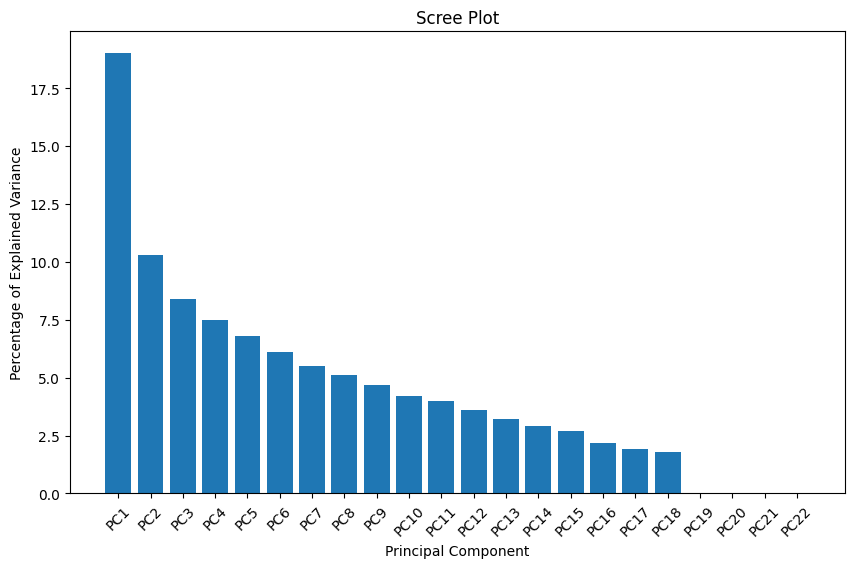

In [33]:
# Plot the scree plot
plt.figure(figsize=(10, 6))  # Create a new figure
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.title('Scree Plot')
plt.xticks(rotation= 45)
plt.show()

**Scree Plot**

The scree plot indicates that the first principal component (PC1) accounts for a substantial portion of the variation in the raw data, making it a strong candidate for the x-axis in the 2-dimensional graph. Similarly, PC2, which explains the next largest amount of variance, will be used for the y-axis

**PCA**

In the next code block, I will use the Principal Component Analysis (PCA) to reduce the dimensionality of the dataset, transforming the 14 original features into 2 principal components (which was done in the previous step). This allows us to visualize the data and the decision boundary in a 2-dimensional space. I will fit our Support Vector Machine (SVM) model using these two principal components (PC1 and PC2) as the x and y coordinates. By creating a mesh grid of points across the transformed feature space, I can classify each point using the trained SVM model and visualize the decision regions. The resulting plot displays the decision surface, showing how the model distinguishes between patients with and without heart disease, with the red and green points representing the two classes and the contour plot indicating the decision boundaries.

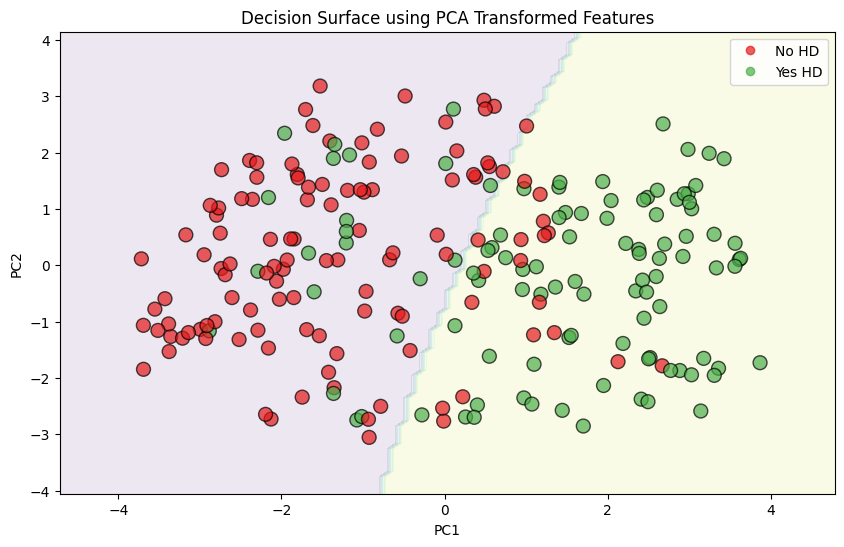

In [34]:
# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# X-axis coordinates after PCA
pc1 = X_train_pca[:, 0]

# Y-axis coordinates after PCA
pc2 = X_train_pca[:, 1]

# Fit the SVM to the x and y axis coordinates after PCA dimension reduction
clf_svm = clf_svm.fit(np.column_stack((pc1, pc2)), y_train)

# Create matrix of points to show the decision regions
x_min = pc1.min() - 1
x_max = pc1.max() + 1
y_min = pc2.min() - 1
y_max = pc2.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

# Classify every point in the matrix with SVM
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

# Use reshape so that each classification (0 or 1) corresponds to a specific point in the matrix
Z = Z.reshape(xx.shape)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Contour plot will be filled according to the classifications (1s & 0s) in Z
ax.contourf(xx, yy, Z, alpha=0.1)

# Create custom colors for the datapoints
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

# Plot the points
scatter = ax.scatter(pc1, pc2, c=y_train, cmap=cmap, s=100, edgecolors='k', alpha=0.7)

# Create a legend
legend = ax.legend(*scatter.legend_elements(), loc='upper right')
legend.get_texts()[0].set_text('No HD')
legend.get_texts()[1].set_text('Yes HD')

# Add labels and titles
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Decision Surface using PCA Transformed Features')
plt.show()

**Decision Surface Plot**

The decision surface plot generated using PCA-transformed features shows the separation of two classes: patients with heart disease (Yes HD) and patients without heart disease (No HD). The plot uses the first principal component (PC1) on the x-axis and the second principal component (PC2) on the y-axis. The colored regions represent the decision boundaries of the SVM model, with the purple region indicating the predicted class of 'No HD' and the yellow region indicating 'Yes HD'.

Each data point is plotted based on its coordinates after PCA transformation. The red circles represent patients without heart disease, while the green circles represent patients with heart disease. The SVM decision boundary effectively separates the two classes, though there are some overlaps and misclassifications.

The majority of red points (No HD) are concentrated in the purple region, while most green points (Yes HD) are in the yellow region, demonstrating the model's ability to distinguish between the two classes. However, some green points appear in the purple region and some red points in the yellow region, indicating instances where the model misclassified the patients. These misclassifications suggest areas for potential improvement, possibly through further hyperparameter tuning or additional feature engineering. Overall, the plot visually confirms that the SVM model, with PCA-transformed features, performs well in classifying patients with and without heart disease, but there is still room for improvement to achieve higher accuracy.

**Conclusion**

In this notebook, I developed a Support Vector Machine (SVM) model to predict heart disease using a dataset from the UCI Machine Learning Repository. I began by preprocessing the data, addressing missing values, and encoding categorical variables. After splitting the data into training and test sets, I scaled the features to ensure the SVM model performed optimally. Using GridSearchCV, I identified the best hyperparameters for the model, which significantly improved its performance.

To visualize the model's decision boundaries, I applied Principal Component Analysis (PCA) to reduce the dataset's dimensionality from 14 features to 2 principal components. This transformation allowed me to plot the decision surface and clearly see how the model distinguishes between patients with and without heart disease. The confusion matrix and the decision boundary plot confirmed that the model has strong predictive power, with an excellent balance between sensitivity and specificity.

Overall, this project demonstrated the effectiveness of SVMs in classification tasks, particularly in medical diagnostics. The process of hyperparameter tuning and dimensionality reduction through PCA was crucial in enhancing the model's performance and interpretability. These techniques, along with thorough data preprocessing, contribute to the robustness and reliability of predictive models in healthcare applications.